In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('../ANN_part2/mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


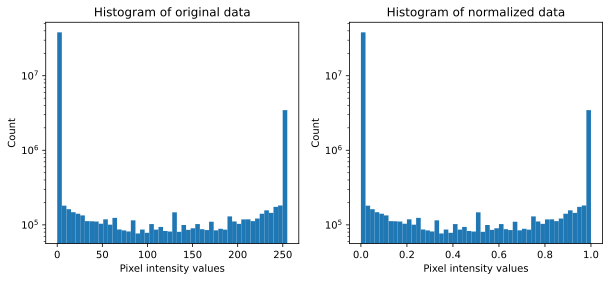

In [3]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [4]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)
        
    model = MnistNet()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [6]:
num_of_epochs = 10
def train_model(model, loss_func, optimizer):
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        model.eval()
        
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
        
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, model

In [7]:
model, loss_func, optimizer = create_model()
train_acc, test_acc, losses, model = train_model(model, loss_func, optimizer)

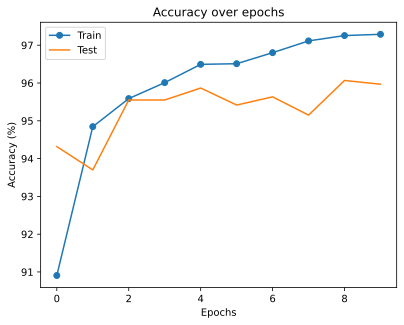

In [8]:
plt.plot(range(num_of_epochs), train_acc, 'o-', range(num_of_epochs), test_acc)
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [18]:
tmp_model, loss_func, optimizer = create_model()
tmp_model.fc1.weight.data = torch.tensor(np.random.normal(0, 1, tmp_model.fc1.weight.data.shape))

torch.Size([64, 784])


In [37]:
variances = np.logspace(-4, 1, 25)
all_train_acc = torch.zeros((len(variances), num_of_epochs))
all_test_acc = torch.zeros((len(variances), num_of_epochs))
models = []

for idx, variance in enumerate(variances):
    model, loss_func, optimizer = create_model()
    for p in model.named_parameters():
        p[1].data = torch.tensor(np.random.normal(0, variance, p[1].data.shape)).float()
    train_acc, test_acc, losses, model = train_model(model, loss_func, optimizer)
    models.append(model)
    
    all_train_acc[idx, :] = torch.tensor(train_acc)
    all_test_acc[idx, :] = torch.tensor(test_acc)

In [38]:
total_test_acc = torch.mean(all_test_acc[:, -3:], axis=1)

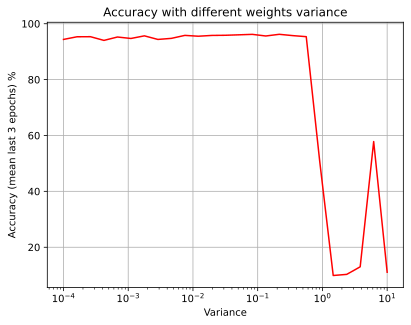

In [39]:
plt.plot(variances, total_test_acc, 'r-')
plt.title('Accuracy with different weights variance')
plt.xlabel('Variance')
plt.ylabel('Accuracy (mean last 3 epochs) %')
plt.xscale('log')
plt.grid()
plt.show()

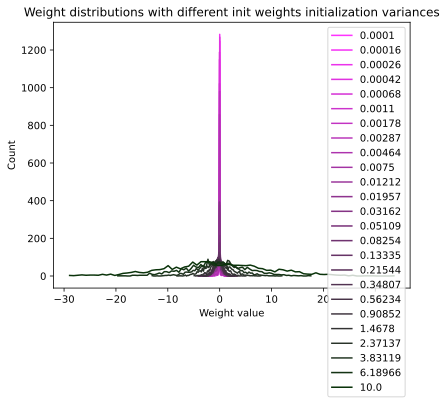

In [42]:
for idx, model in enumerate(models):
    y,x = np.histogram(model.fc1.weight.data.flatten(),80)
    plt.plot((x[1:]+x[:-1])/2, y, color=[1-idx/len(variances), .2, 1-idx/len(variances)], label=f'{round(variances[idx], 5)}')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title("Weight distributions with different init weights initialization variances")
plt.show()